# Task 2 - Aspect Based Sentiment Analysis
The goal of this task is to perform Aspect-Based Sentiment Analysis (ABSA). Students will use the same train.json and val.json files as in Task 1 but will preprocess them differently.


In [1]:
import re
import math
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertModel, BertTokenizer
from transformers import BartModel, BartTokenizer
from transformers import RobertaModel, RobertaTokenizer

from transformers import set_seed
set_seed(42)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



## 2.1 Dataset
### Training Dataset

In [2]:
with open('train.json', 'r') as file:
    train_data = json.load(file)

# print(train_data)

### Validation Dataset

In [3]:
with open('val.json', 'r') as file:
    val_data = json.load(file)

# print(val_data)


## 2.2 Preprocessing
Each aspect term is treated as an independent example, with its corresponding sentiment polarity and index in the sentence. The files should be saved as train task 2.json and val task 2.json.

In [4]:
# function to tokenize the sentence

def tokenize_sentence(sentence):
    # remove all the symbols
    clean_sentence = re.sub(r'[^\w\s]', '', sentence)
    # splitting it on white space
    tokens = clean_sentence.split()
    return tokens


In [5]:
# function to preprocess the data as in the Assignment

def preprocess_data(data):

    # initializing list to store the entries which have been pre-processed
    processed_data = []

    # iterating over all entries in the dataset
    for entry in data:

        original_sentence = entry['sentence']

        tokens = tokenize_sentence(original_sentence)


        for aspect_term in entry['aspect_terms']:

            term = aspect_term['term']
            polarity = aspect_term['polarity']
            term_tokens = tokenize_sentence(term)

            # initializing the index of aspect terms by -1
            index = -1

            # iterating over tokens and checking if the full aspect term matches in the sentence
            for i, token in enumerate(tokens):
                if token.lower() == term_tokens[0].lower():
                    if len(term_tokens) == 1 or all(i+j < len(tokens) and tokens[i+j].lower() == term_tokens[j].lower() for j in range(1, len(term_tokens))):
                        index = i
                        break

            # final entry of pre-processed dataset
            processed_entry = {
                'tokens': tokens,
                'polarity': polarity,
                'aspect_term': term_tokens,
                'index': index
            }

            # adding it to the list
            processed_data.append(processed_entry)

    return processed_data


Preprocessing training dataset

In [6]:
train_final = preprocess_data(train_data)

with open('train_task2.json', 'w') as file:
    json.dump(train_final, file, indent=2)

print(f"Processed {len(train_final)} aspect terms from {len(train_data)} sentences.")
print("Data saved to train_task2.json")

Processed 2961 aspect terms from 2435 sentences.
Data saved to train_task2.json


Preprocessing Validation dataset

In [7]:
val_final = preprocess_data(val_data)

with open('val_task2.json', 'w') as file:
    json.dump(val_final, file, indent=2)

print(f"Processed {len(val_final)} aspect terms from {len(val_data)} sentences.")
print("Data saved to val_task2.json")

Processed 371 aspect terms from 304 sentences.
Data saved to val_task2.json


### Creating Tokenized Dataset
Creating tokenized dataset for using for the architectures.

In [8]:
class ABSADataset(Dataset):

    # initializes dataset
    def __init__(self, data, tokenizer, max_len=128):

        # stores tokenizer
        self.tokenizer = tokenizer
        # stores maximum sequence length
        self.max_len = max_len
        # stores the dataset
        self.data = data


    def __len__(self):
        return len(self.data)

    # returns a sample from the dataset at the given index
    def __getitem__(self, idx):


        sample = self.data[idx]

        tokens = sample['tokens']
        aspect_terms = sample['aspect_term']
        aspect_indices = sample['index']

        # ensuring that aspect terms is in the 'aspect_terms' list
        if not isinstance(aspect_terms, list):
            aspect_terms = [aspect_terms]
        # ensuring that aspect index is in the 'aspect_indices' list
        if not isinstance(aspect_indices, list):
            aspect_indices = [aspect_indices]

        polarity_mapping = {'negative': 0, 'neutral': 1, 'positive': 2, 'conflict': 3}

        # converting polarity mapping from string to numerical format
        if isinstance(sample['polarity'], list):
            polarity = polarity_mapping[sample['polarity'][0]]
        else:
            polarity = polarity_mapping[sample['polarity']]


        # tokenizing the sentence
        sentence = ' '.join(tokens)

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )


        aspect_mask = torch.zeros(self.max_len)

        # adjusting index for special token - CLS (at the start of sentence) and SEP (at the end of a sentence to separate two sentences or sentence and padding)
        start_idx = aspect_indices[0] + 1

        for i in range(len(aspect_terms)):
            pos = start_idx + i
            if pos < self.max_len:
                aspect_mask[pos] = 1.0

        # returning the dataset
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'aspect_mask': aspect_mask,
            'polarity': torch.tensor(polarity, dtype=torch.long)
        }

## 2.3 Model Training
Final Model

In [11]:
class TD_LSTM_GCN(nn.Module):

    def __init__(self, pretrained_bert="bert-base-uncased", hidden_dim=256, output_dim=4, num_gcn_layers=2):
        super(TD_LSTM_GCN, self).__init__()

        # BERT encoder
        self.bert = BertModel.from_pretrained(pretrained_bert)
        bert_output_dim = self.bert.config.hidden_size

        # TD-LSTM components
        self.lstm_left = nn.LSTM(bert_output_dim, hidden_dim // 2, batch_first=True, bidirectional=False)
        self.lstm_right = nn.LSTM(bert_output_dim, hidden_dim // 2, batch_first=True, bidirectional=False)
        self.lstm_target = nn.LSTM(bert_output_dim, hidden_dim, batch_first=True, bidirectional=True)

        # GCN components
        self.gcn_layers = nn.ModuleList([
            GraphConvolution(bert_output_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(num_gcn_layers)
        ])

        # Attention mechanism for combining LSTM and GCN outputs
        self.attention_lstm = nn.Linear(hidden_dim * 2, 1)
        self.attention_gcn = nn.Linear(hidden_dim, 1)

        # Output layer
        self.fc = nn.Linear(hidden_dim * 3, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids, aspect_mask, dependency_matrix=None):

        batch_size, seq_len = input_ids.size()

        # getting BERT embeddings
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        embedded = bert_outputs.last_hidden_state

        # approximation of dependency matrix
        if dependency_matrix is None:
            # Create a simple approximation - nearby words are connected
            dependency_matrix = torch.zeros(batch_size, seq_len, seq_len, device=input_ids.device)

            for i in range(seq_len):
                # Connect word to itself and adjacent words
                for j in range(max(0, i-1), min(seq_len, i+2)):
                    dependency_matrix[:, i, j] = 1.0

            # Mask out padding tokens
            dependency_matrix = dependency_matrix * attention_mask.unsqueeze(1) * attention_mask.unsqueeze(2)

        # Find aspect term positions
        aspect_start_indices = []
        aspect_end_indices = []
        aspect_lengths = []

        for i in range(batch_size):
            # Find the indices where aspect_mask is 1
            aspect_indices = torch.nonzero(aspect_mask[i], as_tuple=True)[0]
            if len(aspect_indices) > 0:
                aspect_start_indices.append(aspect_indices[0].item())
                aspect_end_indices.append(aspect_indices[-1].item())
                aspect_lengths.append(len(aspect_indices))
            else:
                # if no aspect is found pointing to the first non-padding token (using [CLS] token position)
                aspect_start_indices.append(0)
                aspect_end_indices.append(0)
                aspect_lengths.append(1)

        # Process with TD-LSTM
        left_outputs = []
        right_outputs = []
        target_outputs = []

        for i in range(batch_size):
            # Create attention masks for valid tokens
            valid_mask = attention_mask[i].bool()
            valid_token_count = valid_mask.sum().item()

            # Left context
            left_idx = aspect_start_indices[i]
            # Ensure there's atleast 1 token in the left context
            if left_idx > 1 and (left_idx - 1) > 0:

                left_input = embedded[i, 1:left_idx].unsqueeze(0)

                if left_input.size(1) > 0:
                    _, (h_left, _) = self.lstm_left(left_input)
                    left_outputs.append(h_left.squeeze(0))
                else:
                    # Empty left context, use zero vector
                    left_outputs.append(torch.zeros(1, self.lstm_left.hidden_size, device=embedded.device))
            else:
                # No left context, use zero vector
                left_outputs.append(torch.zeros(1, self.lstm_left.hidden_size, device=embedded.device))

            # Right context
            right_idx = aspect_end_indices[i]
            right_limit = valid_token_count - 1

            # Ensure there's atleast 1 token in the right context
            if right_idx < right_limit and (right_limit - right_idx - 1) > 0:

                right_input = embedded[i, right_idx+1:right_limit].flip(dims=[0]).unsqueeze(0)

                if right_input.size(1) > 0:
                    _, (h_right, _) = self.lstm_right(right_input)
                    right_outputs.append(h_right.squeeze(0))
                else:
                    # Empty right context, use zero vector
                    right_outputs.append(torch.zeros(1, self.lstm_right.hidden_size, device=embedded.device))
            else:
                # No right context, use zero vector
                right_outputs.append(torch.zeros(1, self.lstm_right.hidden_size, device=embedded.device))

            # extracting target aspect represemtation
            if aspect_lengths[i] > 0 and aspect_start_indices[i] < aspect_end_indices[i] + 1:

                target_input = embedded[i, aspect_start_indices[i]:aspect_end_indices[i]+1].unsqueeze(0)

                if target_input.size(1) > 0:
                    target_output, _ = self.lstm_target(target_input)

                    target_pooled = F.max_pool1d(target_output.transpose(1, 2), target_input.size(1)).squeeze(2)
                    target_outputs.append(target_pooled)
                else:

                    target_outputs.append(torch.zeros(1, self.lstm_target.hidden_size * 2, device=embedded.device))
            else:

                # Use [CLS] token if empty aspects
                cls_token = embedded[i, 0].unsqueeze(0).unsqueeze(0)
                target_output, _ = self.lstm_target(cls_token)
                target_pooled = target_output.squeeze(1)
                target_outputs.append(target_pooled)

        # Stack the outputs
        left_hidden = torch.cat(left_outputs, dim=0)  # [batch_size, hidden_dim//2]
        right_hidden = torch.cat(right_outputs, dim=0)  # [batch_size, hidden_dim//2]
        target_hidden = torch.cat(target_outputs, dim=0)  # [batch_size, hidden_dim*2]

        # GCN Layers for dependency based feature extraction
        gcn_output = embedded
        for gcn_layer in self.gcn_layers:
            gcn_output = gcn_layer(gcn_output, dependency_matrix)
            gcn_output = F.relu(gcn_output)

        # Extract aspect-specific GCN representations
        aspect_gcn_outputs = []

        for i in range(batch_size):

            aspect_indices = torch.nonzero(aspect_mask[i], as_tuple=True)[0]

            if len(aspect_indices) > 0:

                aspect_gcn = gcn_output[i, aspect_indices]  # [aspect_len, hidden_dim]
                aspect_gcn_pooled = torch.mean(aspect_gcn, dim=0)  # [hidden_dim]
                aspect_gcn_outputs.append(aspect_gcn_pooled.unsqueeze(0))

            else:
                # using [CLS] token representation when no aspect is found
                aspect_gcn_outputs.append(gcn_output[i, 0].unsqueeze(0))

        aspect_gcn_hidden = torch.cat(aspect_gcn_outputs, dim=0)  # [batch_size, hidden_dim]

        # Combine TD-LSTM hidden states
        td_lstm_hidden = torch.cat([left_hidden, right_hidden], dim=1)  # [batch_size, hidden_dim]

        # Attention-based fusion of representations
        lstm_score = torch.sigmoid(self.attention_lstm(target_hidden))  # [batch_size, 1]
        gcn_score = torch.sigmoid(self.attention_gcn(aspect_gcn_hidden))  # [batch_size, 1]

        alpha = lstm_score / (lstm_score + gcn_score + 1e-10)  # [batch_size, 1]
        combined_hidden = alpha * td_lstm_hidden + (1 - alpha) * aspect_gcn_hidden

        # Final representation
        final_hidden = torch.cat([combined_hidden, target_hidden], dim=1)  # [batch_size, hidden_dim*3]

        # Classification
        output = self.fc(final_hidden)
        return output


class GraphConvolution(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
        self.bias = nn.Parameter(torch.FloatTensor(output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, adj):

        batch_size, seq_len, _ = x.size()

        # Add self-loops to the adjacency matrix
        adj = adj + torch.eye(seq_len).unsqueeze(0).expand(batch_size, -1, -1).to(x.device)

        # Normalize adjacency matrix (D^-1/2 A D^-1/2)
        deg = torch.sum(adj, dim=2, keepdim=True)
        norm_adj = adj / torch.sqrt(deg + 1e-10) / torch.sqrt(deg.transpose(1, -1) + 1e-10)

        # Apply graph convolution
        support = torch.matmul(x, self.weight)  # [batch_size, seq_len, output_dim]
        output = torch.matmul(norm_adj, support) + self.bias

        return output



### Function to train the model batch wise

In [12]:
def train_model_batch(model, data_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in tqdm(data_loader):
        # Get data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        aspect_mask = batch['aspect_mask'].to(device)
        polarity = batch['polarity'].to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(input_ids, attention_mask, token_type_ids, aspect_mask)

        # Calculate loss and backpropagate
        loss = criterion(predictions, polarity)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        preds = predictions.argmax(dim=1)
        acc = (preds == polarity).float().mean()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

### Function for evaluating the model

In [13]:
# Function to evaluate the model
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in data_loader:
            # Get data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            aspect_mask = batch['aspect_mask'].to(device)
            polarity = batch['polarity'].to(device)

            # Forward pass
            predictions = model(input_ids, attention_mask, token_type_ids, aspect_mask)

            # Calculate loss and accuracy
            loss = criterion(predictions, polarity)
            preds = predictions.argmax(dim=1)
            acc = (preds == polarity).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)



### Final Function for Training the Model

In [14]:
def train_model(model, train_dataloader, val_dataloader, device, lr_given, n_epochs):
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr_given)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    # n_epochs = 21
    best_val_loss = float('inf')

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')

        # Train and evaluate
        train_loss, train_acc = train_model_batch(model, train_dataloader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)

        # Save metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.5f}%')
        print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.5f}%')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best-absa-model.pt')
            print('Best model saved!')

        print()
    return train_losses, train_accs, val_losses, val_accs




### Plotting
1. Training Loss Vs Validation Loss
2. Training Accuracy Vs Validation Accuracy

In [15]:
def plot(train_losses, train_accs, val_losses, val_accs):
  # Plot training curves
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.ylim(0, 2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accs, label='Train Acc')
  plt.plot(val_accs, label='Val Acc')
  plt.ylim(0, 1)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.savefig('training_curves.png')
  plt.show()

## Loading the Preprocessed Training Dataset

In [16]:
with open("train_task2.json", "r", encoding="utf-8") as file:
    data = json.load(file)

train_final_data = data

## Loading the Preprocesses Validation Dataset

In [17]:
with open("val_task2.json", "r", encoding="utf-8") as file:
    data = json.load(file)

val_final_data = data

### Tokenizing the Dataset for Using in Models

In [18]:
# BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Creating datasets
train_dataset = ABSADataset(train_final_data, tokenizer)
val_dataset = ABSADataset(val_final_data, tokenizer)

for i in range(1):
    print(f"Sample {i}: {train_dataset[i]}\n")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Sample 0: {'input_ids': tensor([ 101, 2021, 1996, 3095, 2001, 2061, 9202, 2000, 2149,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

In [19]:
batch_size = 32
output_dim = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)



### Final Model

Initializing model...
Starting training...
Epoch 1/10


100%|██████████| 93/93 [01:09<00:00,  1.33it/s]


Train Loss: 1.085 | Train Acc: 57.25213%
Val Loss: 1.000 | Val Acc: 56.82566%
Best model saved!

Epoch 2/10


100%|██████████| 93/93 [01:09<00:00,  1.34it/s]


Train Loss: 0.784 | Train Acc: 69.33705%
Val Loss: 0.809 | Val Acc: 69.07895%
Best model saved!

Epoch 3/10


100%|██████████| 93/93 [01:09<00:00,  1.34it/s]


Train Loss: 0.633 | Train Acc: 76.21758%
Val Loss: 0.756 | Val Acc: 71.08004%
Best model saved!

Epoch 4/10


100%|██████████| 93/93 [01:09<00:00,  1.35it/s]


Train Loss: 0.546 | Train Acc: 79.27933%
Val Loss: 0.754 | Val Acc: 70.03838%
Best model saved!

Epoch 5/10


100%|██████████| 93/93 [01:09<00:00,  1.34it/s]


Train Loss: 0.476 | Train Acc: 82.50909%
Val Loss: 0.758 | Val Acc: 70.12061%

Epoch 6/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.420 | Train Acc: 84.29791%
Val Loss: 0.717 | Val Acc: 72.98520%
Best model saved!

Epoch 7/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.365 | Train Acc: 87.04538%
Val Loss: 0.749 | Val Acc: 72.80702%

Epoch 8/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.317 | Train Acc: 88.81839%
Val Loss: 0.778 | Val Acc: 72.02577%

Epoch 9/10


100%|██████████| 93/93 [01:08<00:00,  1.36it/s]


Train Loss: 0.277 | Train Acc: 90.26724%
Val Loss: 0.747 | Val Acc: 74.12281%

Epoch 10/10


100%|██████████| 93/93 [01:08<00:00,  1.35it/s]


Train Loss: 0.245 | Train Acc: 91.87619%
Val Loss: 0.755 | Val Acc: 74.46546%



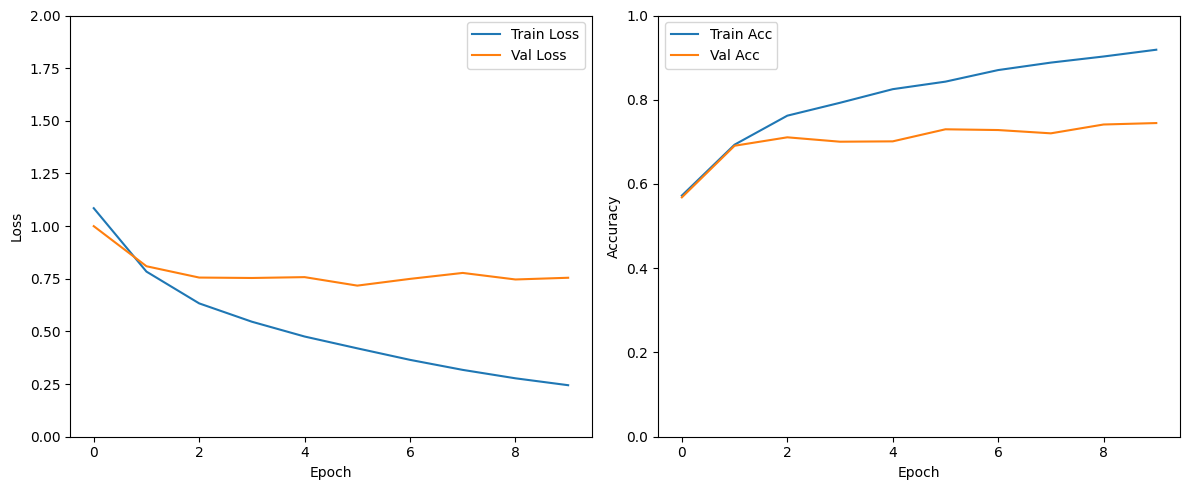

Training complete!


In [22]:
# Model hyperparameters
max_seq_length = 128
hidden_dim = 256
gcn_layers = 2

# Initialize model
print("Initializing model...")
model = TD_LSTM_GCN(
    hidden_dim=hidden_dim,
    num_gcn_layers=gcn_layers,
    output_dim=output_dim)

model = model.to(device)

# Train the model
print("Starting training...")
train_losses, train_accs, val_losses, val_accs = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device, lr_given = 4e-6, n_epochs=10)


# Plot training results
plot(train_losses, train_accs, val_losses, val_accs)

print("Training complete!")


## 2.6 Additional Task

In [23]:
class BERTForABSA(nn.Module):
    def __init__(self, pretrained_model="bert-base-uncased", output_dim=4):
        super(BERTForABSA, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.1)
        # Double the hidden size as we'll be combining aspect and context representations
        self.classifier = nn.Linear(self.bert.config.hidden_size * 2, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids=None, aspect_mask=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        sequence_output = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Get weighted aspect representation using the aspect mask
        aspect_mask = aspect_mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
        aspect_sum = torch.sum(sequence_output * aspect_mask, dim=1)  # [batch_size, hidden_size]
        aspect_mask_sum = torch.sum(aspect_mask, dim=1) + 1e-10  # Add small epsilon to avoid division by zero
        aspect_representation = aspect_sum / aspect_mask_sum  # [batch_size, hidden_size]

        # Get sentence representation from [CLS] token
        sentence_representation = sequence_output[:, 0, :]  # [batch_size, hidden_size]

        # Concatenate aspect and sentence representations
        combined_representation = torch.cat([sentence_representation, aspect_representation], dim=1)
        combined_representation = self.dropout(combined_representation)

        # Pass through classifier
        logits = self.classifier(combined_representation)
        return logits


class BARTForABSA(nn.Module):
    def __init__(self, pretrained_model="facebook/bart-base", output_dim=4):
        super(BARTForABSA, self).__init__()
        self.bart = BartModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.1)
        # Double the hidden size as we'll be combining aspect and context representations
        self.classifier = nn.Linear(self.bart.config.d_model * 2, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids=None, aspect_mask=None):
        # BART doesn't use token_type_ids, so we ignore it
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        sequence_output = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Get weighted aspect representation using the aspect mask
        aspect_mask = aspect_mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
        aspect_sum = torch.sum(sequence_output * aspect_mask, dim=1)  # [batch_size, hidden_size]
        aspect_mask_sum = torch.sum(aspect_mask, dim=1) + 1e-10  # Add small epsilon to avoid division by zero
        aspect_representation = aspect_sum / aspect_mask_sum  # [batch_size, hidden_size]

        # Get sentence representation from first token
        sentence_representation = sequence_output[:, 0, :]  # [batch_size, hidden_size]

        # Concatenate aspect and sentence representations
        combined_representation = torch.cat([sentence_representation, aspect_representation], dim=1)
        combined_representation = self.dropout(combined_representation)

        # Pass through classifier
        logits = self.classifier(combined_representation)
        return logits


class RoBERTaForABSA(nn.Module):
    def __init__(self, pretrained_model="roberta-base", output_dim=4):
        super(RoBERTaForABSA, self).__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.1)

        # Double the hidden size as we'll be combining aspect and context representations
        self.classifier = nn.Linear(self.roberta.config.hidden_size * 2, output_dim)

    def forward(self, input_ids, attention_mask, token_type_ids=None, aspect_mask=None):
        # RoBERTa doesn't use token_type_ids, so we ignore it
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        sequence_output = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Get weighted aspect representation using the aspect mask
        aspect_mask = aspect_mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
        aspect_sum = torch.sum(sequence_output * aspect_mask, dim=1)  # [batch_size, hidden_size]
        aspect_mask_sum = torch.sum(aspect_mask, dim=1) + 1e-10  # Add small epsilon to avoid division by zero
        aspect_representation = aspect_sum / aspect_mask_sum  # [batch_size, hidden_size]

        # Get sentence representation from first token
        sentence_representation = sequence_output[:, 0, :]  # [batch_size, hidden_size]

        # Concatenate aspect and sentence representations
        combined_representation = torch.cat([sentence_representation, aspect_representation], dim=1)
        combined_representation = self.dropout(combined_representation)

        # Pass through classifier
        logits = self.classifier(combined_representation)
        return logits

In [ ]:
# Initialize tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Create datasets
train_dataset_bert = ABSADataset(train_final_data, bert_tokenizer)
val_dataset_bert = ABSADataset(val_final_data, bert_tokenizer)

train_dataset_bart = ABSADataset(train_final_data, bart_tokenizer)
val_dataset_bart = ABSADataset(val_final_data, bart_tokenizer)

train_dataset_roberta = ABSADataset(train_final_data, roberta_tokenizer)
val_dataset_roberta = ABSADataset(val_final_data, roberta_tokenizer)

# Create dataloaders
train_dataloader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)
val_dataloader_bert = DataLoader(val_dataset_bert, batch_size=32, shuffle=False)

train_dataloader_bart = DataLoader(train_dataset_bart, batch_size=32, shuffle=True)
val_dataloader_bart = DataLoader(val_dataset_bart, batch_size=32, shuffle=False)

train_dataloader_roberta = DataLoader(train_dataset_roberta, batch_size=32, shuffle=True)
val_dataloader_roberta = DataLoader(val_dataset_roberta, batch_size=32, shuffle=False)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dim = 4

bert_model = BERTForABSA(output_dim=output_dim).to(device)
bart_model = BARTForABSA(output_dim=output_dim).to(device)
roberta_model = RoBERTaForABSA(output_dim=output_dim).to(device)




In [25]:
def train_model_finetune(model, train_dataloader, val_dataloader, device, lr_given, n_epochs):
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr_given)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    # n_epochs = 21
    best_val_loss = float('inf')

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')

        # Train and evaluate
        train_loss, train_acc = train_model_batch(model, train_dataloader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)

        # Save metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.5f}%')
        print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.5f}%')

        # # Save best model
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     torch.save(model.state_dict(), 'best-absa-model.pt')
        #     print('Best model saved!')

        print()
    return train_losses, train_accs, val_losses, val_accs




### BERT

Fine-tuning BERT...
Epoch 1/10


100%|██████████| 93/93 [00:59<00:00,  1.57it/s]


Train Loss: 0.927 | Train Acc: 61.57495%
Val Loss: 0.829 | Val Acc: 67.85910%

Epoch 2/10


100%|██████████| 93/93 [00:58<00:00,  1.59it/s]


Train Loss: 0.627 | Train Acc: 76.25119%
Val Loss: 0.736 | Val Acc: 69.68202%

Epoch 3/10


100%|██████████| 93/93 [00:58<00:00,  1.58it/s]


Train Loss: 0.493 | Train Acc: 81.96750%
Val Loss: 0.677 | Val Acc: 72.82072%

Epoch 4/10


100%|██████████| 93/93 [00:58<00:00,  1.58it/s]


Train Loss: 0.392 | Train Acc: 85.76455%
Val Loss: 0.643 | Val Acc: 72.38213%

Epoch 5/10


100%|██████████| 93/93 [00:58<00:00,  1.59it/s]


Train Loss: 0.315 | Train Acc: 88.51202%
Val Loss: 0.669 | Val Acc: 73.94463%

Epoch 6/10


100%|██████████| 93/93 [00:58<00:00,  1.59it/s]


Train Loss: 0.238 | Train Acc: 91.93944%
Val Loss: 0.667 | Val Acc: 74.98629%

Epoch 7/10


100%|██████████| 93/93 [00:58<00:00,  1.59it/s]


Train Loss: 0.193 | Train Acc: 93.65315%
Val Loss: 0.697 | Val Acc: 76.98739%

Epoch 8/10


100%|██████████| 93/93 [00:58<00:00,  1.59it/s]


Train Loss: 0.152 | Train Acc: 95.26605%
Val Loss: 0.688 | Val Acc: 76.72697%

Epoch 9/10


100%|██████████| 93/93 [00:58<00:00,  1.59it/s]


Train Loss: 0.111 | Train Acc: 96.64769%
Val Loss: 0.729 | Val Acc: 74.98629%

Epoch 10/10


100%|██████████| 93/93 [00:58<00:00,  1.59it/s]


Train Loss: 0.090 | Train Acc: 97.58065%
Val Loss: 0.768 | Val Acc: 74.64364%



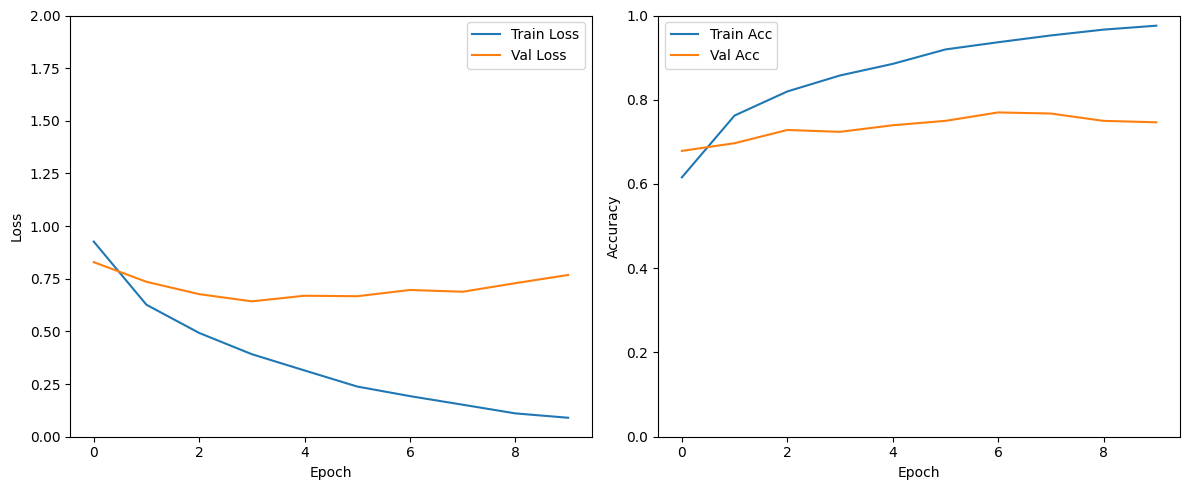

In [26]:
# Fine-tune and evaluate BERT
print("Fine-tuning BERT...")
bert_train_losses, bert_train_accs, bert_val_losses, bert_val_accs = train_model_finetune(
    model=bert_model,
    train_dataloader=train_dataloader_bert,
    val_dataloader=val_dataloader_bert,
    device=device,
    lr_given=1e-5,
    n_epochs=10
)
plot(bert_train_losses, bert_train_accs, bert_val_losses, bert_val_accs)


### BART

Fine-tuning BART...
Epoch 1/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 1.116 | Train Acc: 57.58025%
Val Loss: 0.923 | Val Acc: 64.21327%

Epoch 2/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.777 | Train Acc: 69.57622%
Val Loss: 0.823 | Val Acc: 62.84265%

Epoch 3/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.655 | Train Acc: 75.95272%
Val Loss: 0.875 | Val Acc: 66.73520%

Epoch 4/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.513 | Train Acc: 80.48110%
Val Loss: 0.960 | Val Acc: 67.17379%

Epoch 5/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.443 | Train Acc: 84.31175%
Val Loss: 1.134 | Val Acc: 60.73191%

Epoch 6/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.381 | Train Acc: 86.10057%
Val Loss: 1.101 | Val Acc: 64.65186%

Epoch 7/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.317 | Train Acc: 89.05756%
Val Loss: 0.980 | Val Acc: 64.99452%

Epoch 8/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.268 | Train Acc: 90.83847%
Val Loss: 1.048 | Val Acc: 63.59649%

Epoch 9/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.297 | Train Acc: 89.29277%
Val Loss: 1.141 | Val Acc: 62.12993%

Epoch 10/10


100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Train Loss: 0.266 | Train Acc: 90.25538%
Val Loss: 1.218 | Val Acc: 65.95395%



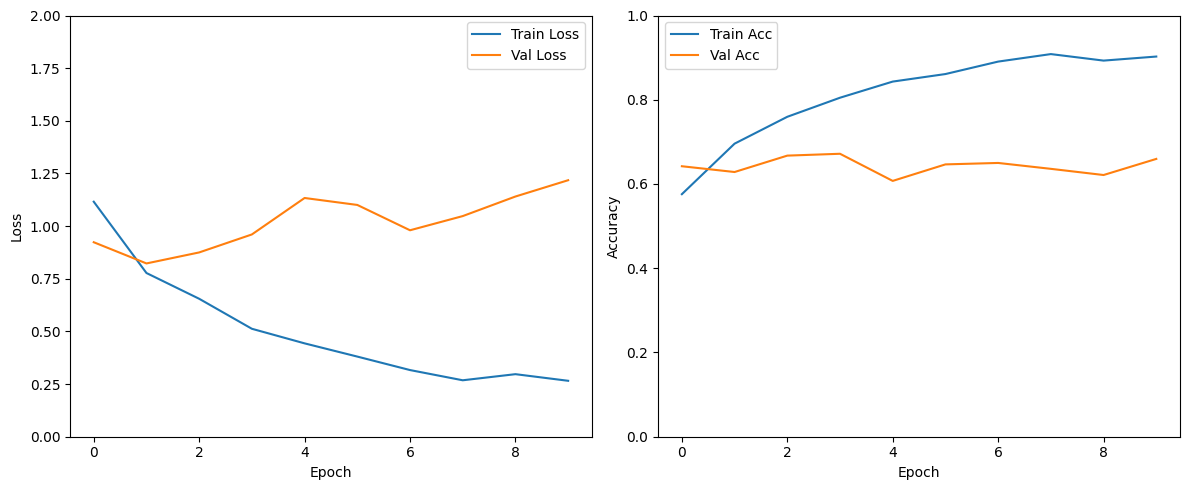

In [27]:
# Fine-tune and evaluate BART
print("Fine-tuning BART...")
bart_train_losses, bart_train_accs, bart_val_losses, bart_val_accs = train_model_finetune(
    model=bart_model,
    train_dataloader=train_dataloader_bart,
    val_dataloader=val_dataloader_bart,
    device=device,
    lr_given=2e-4,
    n_epochs=10
)
plot(bart_train_losses, bart_train_accs, bart_val_losses, bart_val_accs)



### RoBERTa

Fine-tuning RoBERTa...
Epoch 1/10


100%|██████████| 93/93 [00:58<00:00,  1.60it/s]


Train Loss: 3.621 | Train Acc: 45.85508%
Val Loss: 2.062 | Val Acc: 56.56524%

Epoch 2/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.282 | Train Acc: 52.77119%
Val Loss: 1.701 | Val Acc: 56.56524%

Epoch 3/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.149 | Train Acc: 54.29910%
Val Loss: 1.297 | Val Acc: 56.56524%

Epoch 4/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.190 | Train Acc: 51.58918%
Val Loss: 1.369 | Val Acc: 56.56524%

Epoch 5/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.168 | Train Acc: 55.04230%
Val Loss: 1.361 | Val Acc: 56.56524%

Epoch 6/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.142 | Train Acc: 53.38789%
Val Loss: 1.282 | Val Acc: 56.56524%

Epoch 7/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.165 | Train Acc: 52.54783%
Val Loss: 1.259 | Val Acc: 56.56524%

Epoch 8/10


100%|██████████| 93/93 [00:57<00:00,  1.60it/s]


Train Loss: 1.137 | Train Acc: 53.18232%
Val Loss: 1.112 | Val Acc: 56.56524%

Epoch 9/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.138 | Train Acc: 53.82867%
Val Loss: 1.109 | Val Acc: 56.56524%

Epoch 10/10


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]


Train Loss: 1.123 | Train Acc: 55.17671%
Val Loss: 1.149 | Val Acc: 56.56524%



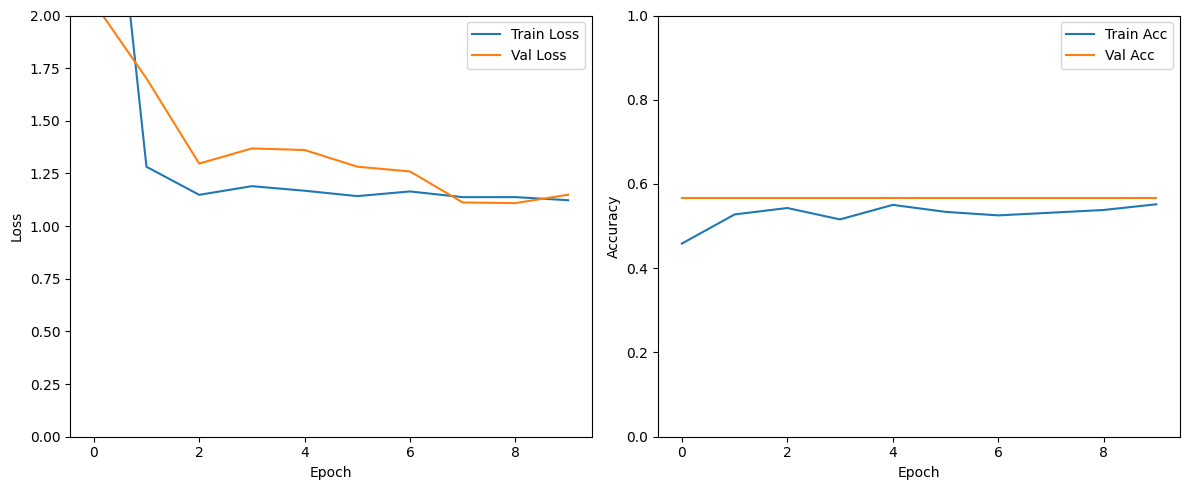

In [28]:
# Fine-tune and evaluate RoBERTa
print("Fine-tuning RoBERTa...")
roberta_train_losses, roberta_train_accs, roberta_val_losses, roberta_val_accs = train_model_finetune(
    model=roberta_model,
    train_dataloader=train_dataloader_roberta,
    val_dataloader=val_dataloader_roberta,
    device=device,
    lr_given=5e-2,
    n_epochs=10
)
plot(roberta_train_losses, roberta_train_accs, roberta_val_losses, roberta_val_accs)

## Task 2.5

In [29]:
import json
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score

def test_inference(test_file_path, model_path='best-absa-model.pt'):

    # Load test data
    with open(test_file_path, "r", encoding="utf-8") as file:
        test_data = json.load(file)

    # Preprocess test data - assuming you have the preprocess_data function
    test_final = preprocess_data(test_data)

    # Initialize BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create test dataset
    test_dataset = ABSADataset(test_final, tokenizer)

    # Create dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    # Load the trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize your model architecture - you'll need to define this based on your specific model
    # For example:
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    model = TD_LSTM_GCN(
    hidden_dim=256,
    num_gcn_layers=2,
    output_dim=4)

    # Load state dictionary
    model_state = torch.load(model_path, map_location=device)

    model.load_state_dict(model_state)

    model.to(device)
    model.eval()

    # Perform inference
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            aspect_mask = batch['aspect_mask'].to(device)
            polarity = batch['polarity'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask, token_type_ids, aspect_mask)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and labels
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(polarity.cpu().numpy())
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

test_inference("val.json")

Test Accuracy: 72.78%
